# Obesity Estimation - Feature Engineering and Machine Learning Models

### In this notebook we will implement various Machine Learning Classification alogrithms to select the best performing model
1) Decision Tree </br>
2) Random Forest</br>
3) KNN </br>
4) XGBClassifier</br>


### We will use the following steps:
##### Split the Dataset:
Split the dataset into training and test sets before applying transformations to avoid data leakage.
##### One-Hot Encoding:
Apply one-hot encoding only to the training set using fit_transform.</br>
Use the same encoder to transform the test set with transform, ensuring consistency.</br>
Handle unknown categories with handle_unknown='ignore'.
##### Label Encoding for Target Variable:
Apply label encoding to the entire target column (train + test) for consistent label mappings across splits.
This is safe as it will not allow information to leak from features to the model.
##### Feature Scaling:
Apply scaling (e.g., StandardScaler or MinMaxScaler) only to the training set using fit_transform.
Use the same scaler to transform the test set with transform.
##### Save Encoders/Scalers:
Save the fitted encoders and scalers to ensure consistent transformations for future data.

#####  GridsearchCV and 5-fold cross-validation to compare the accuracies.

In [1]:
import pandas as pd

In [2]:
# Read data and convert to a dataframe
clean_data_df = pd.read_csv(r'../data/clean_data.csv')

clean_data_df.info()

clean_data_df.drop('BMI', axis='columns', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087 entries, 0 to 2086
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Gender                     2087 non-null   object 
 1   Age                        2087 non-null   float64
 2   Height                     2087 non-null   float64
 3   Weight                     2087 non-null   float64
 4   Family_History             2087 non-null   object 
 5   High_Cal_Foods_Frequently  2087 non-null   object 
 6   Freq_Veg                   2087 non-null   float64
 7   Num_Meals                  2087 non-null   float64
 8   Snacking                   2087 non-null   object 
 9   Smoke                      2087 non-null   object 
 10  Water_Intake               2087 non-null   float64
 11  Calorie_Monitoring         2087 non-null   object 
 12  Phys_Activity              2087 non-null   float64
 13  Tech_Use                   2087 non-null   float

In [3]:
# Feature columns by preprocessing type: categorical and continous

cat_cols = ['Gender', 'Family_History', 'High_Cal_Foods_Frequently', 'Snacking','Smoke', 'Calorie_Monitoring', 'Freq_Alcohol', 'Transportation']

num_cols = ['Age', 'Height', 'Weight', 'Freq_Veg', 'Num_Meals','Water_Intake', 'Phys_Activity', 'Tech_Use']

### Define dataframes X and y 

In [4]:
X = clean_data_df.drop('Obesity_Level',axis=1)  
y = clean_data_df['Obesity_Level'] 

X.shape, y.shape

((2087, 16), (2087,))

### Train test split - stratified splitting
Stratified splitting means that when you generate a training / validation dataset split, it will attempt to keep the same percentages of classes in each split.

These dataset divisions are usually generated randomly according to a target variable. However, when doing so, the proportions of the target variable among the different splits can differ, especially in the case of small datasets.

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1669, 16), (418, 16), (1669,), (418,))

### Scaling - OneHot for cat columns and Standard scaling for num columns

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
Sscaler = StandardScaler().set_output(transform="pandas")
# Encoding multiple columns. 
transformer = make_column_transformer((Sscaler, num_cols), (OneHotEncoder(handle_unknown='ignore'), 
     cat_cols),verbose=True,verbose_feature_names_out=True, remainder='drop')

transformer

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['Age', 'Height', 'Weight', 'Freq_Veg',
                                  'Num_Meals', 'Water_Intake', 'Phys_Activity',
                                  'Tech_Use']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Gender', 'Family_History',
                                  'High_Cal_Foods_Frequently', 'Snacking',
                                  'Smoke', 'Calorie_Monitoring', 'Freq_Alcohol',
                                  'Transportation'])],
                  verbose=True)

### X_train encoding

In [8]:
# Transforming
transformed = transformer.fit_transform(X_train)
# Transformating back
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
# One-hot encoding removed an index. Let's put it back:
transformed_df.index = X_train.index
# Joining tables
X_train = pd.concat([X_train, transformed_df], axis=1)
# Dropping old categorical columns
X_train.drop(cat_cols, axis=1, inplace=True)
# Dropping old num columns
X_train.drop(num_cols, axis=1, inplace=True)
# CHecking result
#print(X_train.head())
print(X_train.columns)
print(X_train.shape)

[ColumnTransformer]  (1 of 2) Processing standardscaler, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing onehotencoder, total=   0.0s
Index(['standardscaler__Age', 'standardscaler__Height',
       'standardscaler__Weight', 'standardscaler__Freq_Veg',
       'standardscaler__Num_Meals', 'standardscaler__Water_Intake',
       'standardscaler__Phys_Activity', 'standardscaler__Tech_Use',
       'onehotencoder__Gender_Female', 'onehotencoder__Gender_Male',
       'onehotencoder__Family_History_no', 'onehotencoder__Family_History_yes',
       'onehotencoder__High_Cal_Foods_Frequently_no',
       'onehotencoder__High_Cal_Foods_Frequently_yes',
       'onehotencoder__Snacking_Always', 'onehotencoder__Snacking_Frequently',
       'onehotencoder__Snacking_Sometimes', 'onehotencoder__Snacking_no',
       'onehotencoder__Smoke_no', 'onehotencoder__Smoke_yes',
       'onehotencoder__Calorie_Monitoring_no',
       'onehotencoder__Calorie_Monitoring_yes',
       'onehotencoder__Freq_Alcohol_A

### X_test encoding

In [9]:
# Transforming
transformed = transformer.transform(X_test)
# Transformating back
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
# One-hot encoding removed an index. Let's put it back:
transformed_df.index = X_test.index
# Joining tables
X_test = pd.concat([X_test, transformed_df], axis=1)
# Dropping old categorical columns
X_test.drop(cat_cols, axis=1, inplace=True)
# Dropping old num columns
X_test.drop(num_cols, axis=1, inplace=True)
# CHecking result
X_test.head()

,standardscaler__Age,standardscaler__Height,standardscaler__Weight,standardscaler__Freq_Veg,standardscaler__Num_Meals,standardscaler__Water_Intake,standardscaler__Phys_Activity,standardscaler__Tech_Use,onehotencoder__Gender_Female,onehotencoder__Gender_Male,...,onehotencoder__Calorie_Monitoring_yes,onehotencoder__Freq_Alcohol_Always,onehotencoder__Freq_Alcohol_Frequently,onehotencoder__Freq_Alcohol_Sometimes,onehotencoder__Freq_Alcohol_no,onehotencoder__Transportation_Automobile,onehotencoder__Transportation_Bike,onehotencoder__Transportation_Motorbike,onehotencoder__Transportation_Public_Transportation,onehotencoder__Transportation_Walking
1153,-0.690071,-1.202029,-0.537291,1.084280,1.512030,-0.000656,0.376859,0.550747,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
132,0.899810,0.736866,0.848928,1.084280,0.391801,-1.644954,1.182627,-1.095082,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1923,-0.587828,0.401573,1.579131,1.084280,0.391801,-0.334381,0.499952,0.495086,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
846,-1.165664,-1.047678,-0.831968,1.008997,-2.224232,-0.000656,-0.324357,1.117030,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1246,0.821665,1.347473,0.839435,-0.801583,0.231677,0.588066,-0.155934,1.895629,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
print(X_train.columns, X_train.shape)

Index(['standardscaler__Age', 'standardscaler__Height',
       'standardscaler__Weight', 'standardscaler__Freq_Veg',
       'standardscaler__Num_Meals', 'standardscaler__Water_Intake',
       'standardscaler__Phys_Activity', 'standardscaler__Tech_Use',
       'onehotencoder__Gender_Female', 'onehotencoder__Gender_Male',
       'onehotencoder__Family_History_no', 'onehotencoder__Family_History_yes',
       'onehotencoder__High_Cal_Foods_Frequently_no',
       'onehotencoder__High_Cal_Foods_Frequently_yes',
       'onehotencoder__Snacking_Always', 'onehotencoder__Snacking_Frequently',
       'onehotencoder__Snacking_Sometimes', 'onehotencoder__Snacking_no',
       'onehotencoder__Smoke_no', 'onehotencoder__Smoke_yes',
       'onehotencoder__Calorie_Monitoring_no',
       'onehotencoder__Calorie_Monitoring_yes',
       'onehotencoder__Freq_Alcohol_Always',
       'onehotencoder__Freq_Alcohol_Frequently',
       'onehotencoder__Freq_Alcohol_Sometimes',
       'onehotencoder__Freq_Alcohol_n

In [11]:
# Setting new feature names

X_train.columns = ['Age', 'Height', 'Weight', 'Freq_Veg', 'Num_Meals', 'Water_Intake',
       'Phys_Activity', 'Tech_Use', 'Gender_Female',
       'Gender_Male', 'Family_History_no',
       'Family_History_yes',
       'High_Cal_Foods_Frequently_no',
       'High_Cal_Foods_Frequently_yes',
       'Snacking_Always', 'Snacking_Frequently',
       'Snacking_Sometimes', 'Snacking_no',
       'Smoke_no', 'Smoke_yes',
       'Calorie_Monitoring_no',
       'Calorie_Monitoring_yes',
       'Freq_Alcohol_Always',
       'Freq_Alcohol_Frequently',
       'Freq_Alcohol_Sometimes',
       'Freq_Alcohol_no',
       'Transportation_Automobile',
       'Transportation_Bike',
       'Transportation_Motorbike',
       'Transportation_Public_Transportation',
       'Transportation_Walking']

X_test.columns = ['Age', 'Height', 'Weight', 'Freq_Veg', 'Num_Meals', 'Water_Intake',
       'Phys_Activity', 'Tech_Use', 'Gender_Female',
       'Gender_Male', 'Family_History_no',
       'Family_History_yes',
       'High_Cal_Foods_Frequently_no',
       'High_Cal_Foods_Frequently_yes',
       'Snacking_Always', 'Snacking_Frequently',
       'Snacking_Sometimes', 'Snacking_no',
       'Smoke_no', 'Smoke_yes',
       'Calorie_Monitoring_no',
       'Calorie_Monitoring_yes',
       'Freq_Alcohol_Always',
       'Freq_Alcohol_Frequently',
       'Freq_Alcohol_Sometimes',
       'Freq_Alcohol_no',
       'Transportation_Automobile',
       'Transportation_Bike',
       'Transportation_Motorbike',
       'Transportation_Public_Transportation',
       'Transportation_Walking']
# After renaming the columns

X_train.head()


,Age,Height,Weight,Freq_Veg,Num_Meals,Water_Intake,Phys_Activity,Tech_Use,Gender_Female,Gender_Male,...,Calorie_Monitoring_yes,Freq_Alcohol_Always,Freq_Alcohol_Frequently,Freq_Alcohol_Sometimes,Freq_Alcohol_no,Transportation_Automobile,Transportation_Bike,Transportation_Motorbike,Transportation_Public_Transportation,Transportation_Walking
1549,0.248290,0.705537,1.045026,-0.375885,0.391801,0.253102,0.308538,-0.452916,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1574,1.008501,-0.608067,0.505277,1.016483,-0.755149,-1.644954,0.823971,-0.073903,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1155,3.702329,0.457500,-0.078269,0.207948,0.391801,-1.403908,-0.827757,-1.095082,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
610,-0.208354,0.416482,-1.265285,-0.345947,0.391801,-0.252848,1.731352,0.245475,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
906,-0.523216,-1.012212,-0.725998,-0.801583,0.596256,1.643643,0.204484,-0.952112,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Apply Label encoder

#### Encoding y_train

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

#y_train.head(10) , y_train_encoded[0:10]




#### Encoding y_test

In [13]:
le_test = LabelEncoder()
y_test_encoded = le_test.fit_transform(y_test)
y_test.head(10) , y_test_encoded[0:10]

(1153    Overweight_Level_II
 132          Obesity_Type_I
 1923       Obesity_Type_III
 846      Overweight_Level_I
 1246         Obesity_Type_I
 1236         Obesity_Type_I
 1372         Obesity_Type_I
 1010    Overweight_Level_II
 337        Obesity_Type_III
 1524        Obesity_Type_II
 Name: Obesity_Level, dtype: object,
 array([6, 2, 4, 5, 2, 2, 2, 6, 4, 3]))

### Classifier Models 

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

##### Models in consideration - RandomForest, DecisionTree, KNN, XGBoost

In [15]:
models={'RandomForest':RandomForestClassifier(),
        'DecisionTree':DecisionTreeClassifier(),
        'KNeighbors':KNeighborsClassifier(),
        'xgbc': XGBClassifier()}

##### Scoring for measuring model performance

In [16]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')}

##### Model Evalution

In [17]:
# %reload ../models/Models_eval.py

from sklearn.model_selection import GridSearchCV

def grid_search_cv_eval(X,Y, models, param_grid, scorings,cross_validation):

    best_models = {}
    result = {}
    for model in models:
        print(result)
        print(f"\nRunning GridSearch for {model}...")
        gsv = GridSearchCV(
            estimator=models[model],
            param_grid=param_grid[model],
            cv=cross_validation,
            scoring=scorings,
            refit='accuracy'  # Primary metric for model selection
        )
        gsv.fit(X, Y)
        best_models[model] = gsv.best_estimator_
        best_index = gsv.best_index_
        print(f'Best parameters for {model}: {gsv.best_params_}')
        print(f'Best accuracy: {gsv.cv_results_["mean_test_accuracy"][best_index]:.4f}')
        print(f'Best precision: {gsv.cv_results_["mean_test_precision"][best_index]:.4f}')
        print(f'Best recall: {gsv.cv_results_["mean_test_recall"][best_index]:.4f}')
        result[model] = {"parameter":gsv.best_params_,"accuracy":gsv.cv_results_["mean_test_accuracy"][best_index], "precision": gsv.cv_results_["mean_test_precision"][best_index],"recall": gsv.cv_results_["mean_test_recall"][best_index]}

    return best_models, result

In [18]:
from sklearn.model_selection import cross_val_score

# Define the function to compare models with default parameters
def evaluate_models(X, Y, models, scorings, cross_validation):
    result = {}
    
    # Loop through models and evaluate each one
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        
        # Evaluate using the defined scoring metrics
        model_scores = {}
        for score_name, scorer in scorings.items():
            score = cross_val_score(model, X, Y, cv=cross_validation, scoring=scorer)
            model_scores[score_name] = score.mean()
        
        # Store results
        result[model_name] = model_scores
        
        # Print the results
        print(f"Accuracy: {model_scores['accuracy']:.4f}")
        print(f"Precision: {model_scores['precision']:.4f}")
        print(f"Recall: {model_scores['recall']:.4f}")
        print(f"F1 Score: {model_scores['f1']:.4f}")
    
    return result

In [19]:
result = evaluate_models(X_train, y_train_encoded, models, scoring, 5)


Evaluating RandomForest...
Accuracy: 0.9329
Precision: 0.9383
Recall: 0.9347
F1 Score: 0.9363

Evaluating DecisionTree...
Accuracy: 0.9173
Precision: 0.9223
Recall: 0.9209
F1 Score: 0.9196

Evaluating KNeighbors...
Accuracy: 0.8113
Precision: 0.8105
Recall: 0.8113
F1 Score: 0.7941

Evaluating xgbc...
Accuracy: 0.9629
Precision: 0.9633
Recall: 0.9629
F1 Score: 0.9628


## Confusion Matrix

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# y_pred = best_models['xgbc'].predict(X_test)

# cm = confusion_matrix(y_test_encoded, y_pred)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=le.classes_, yticklabels=le.classes_)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

NameError: name 'best_models' is not defined

### Models Performance Visuals

In [ ]:
result_df = pd.DataFrame(result).T


#### Accuracy Comparison



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



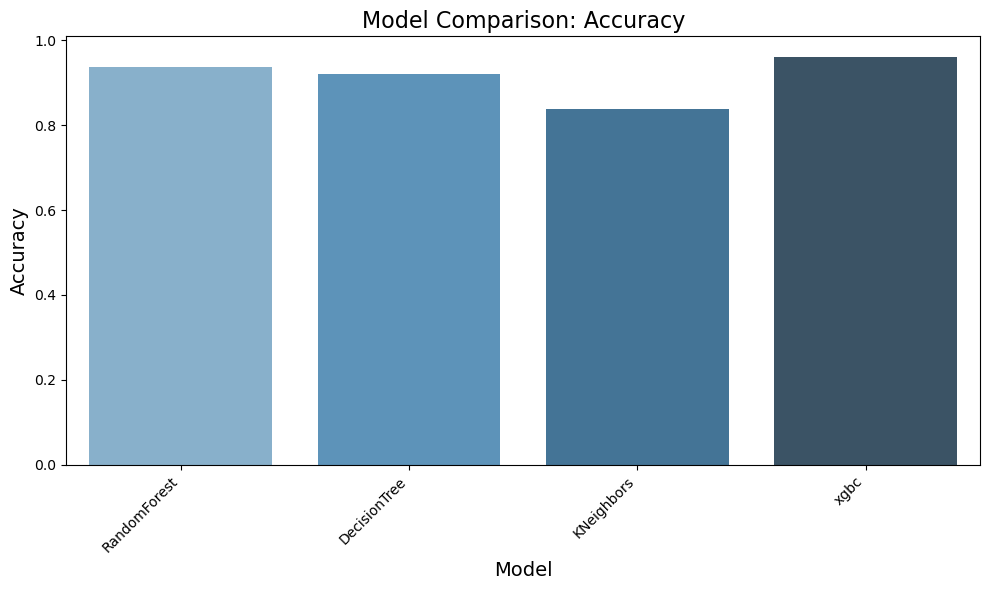

In [ ]:
# Plot Accuracy
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.figure(figsize=(10, 6))
sns.barplot(x=result_df.index, y='accuracy', data=result_df, palette="Blues_d")
plt.title('Model Comparison: Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Precision Comparison



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



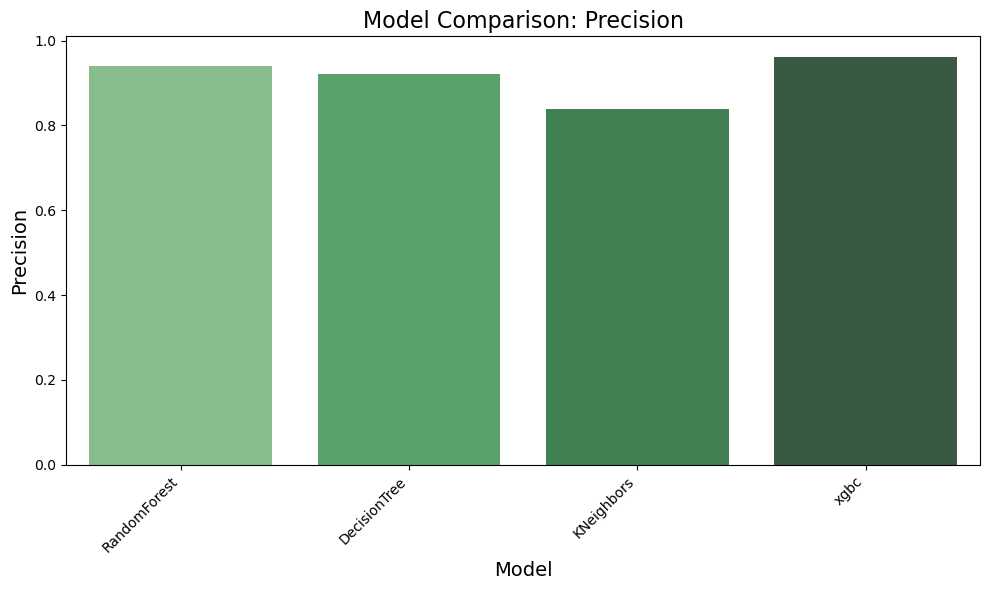

In [ ]:
# Plot Precision
plt.figure(figsize=(10, 6))
sns.barplot(x=result_df.index, y='precision', data=result_df, palette="Greens_d")
plt.title('Model Comparison: Precision', fontsize=16)
plt.ylabel('Precision', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Recall Comparison



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



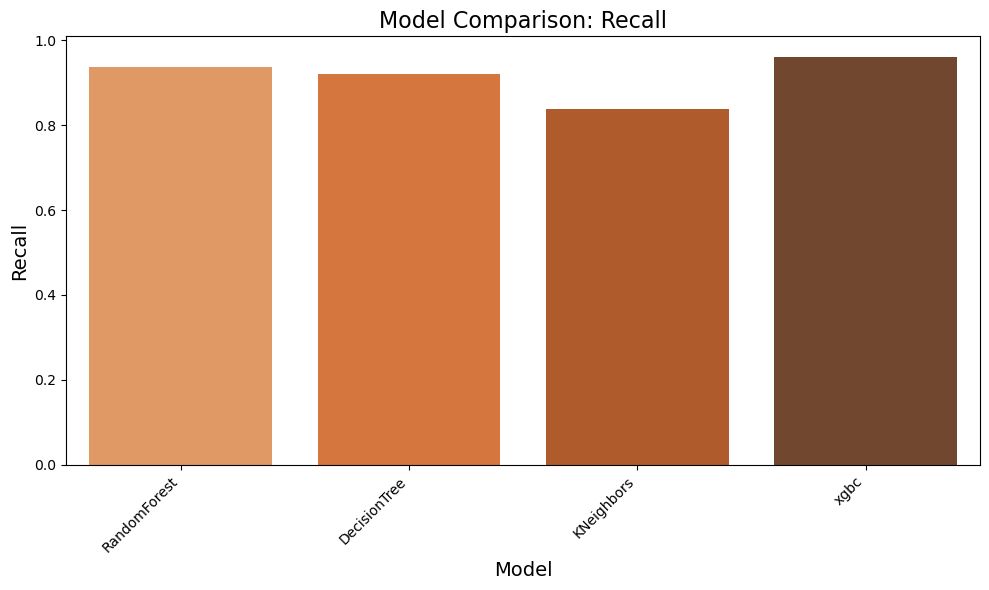

In [ ]:
# Plot Precision
plt.figure(figsize=(10, 6))
sns.barplot(x=result_df.index, y='recall', data=result_df, palette="Oranges_d")
plt.title('Model Comparison: Recall', fontsize=16)
plt.ylabel('Recall', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Based on Visuals above we can clearly notice that RandomForest and XGBC models are showing good results. We will tune the parameters next to find the best suitable model

## Creating a comparison table for the Models

In [ ]:
models = ['RandomForest', 'DecisionTree', 'KNeighbors', 'xgbc']

result_df['f1_score'] = 2 * (result_df['precision'] * result_df['recall']) / (result_df['precision'] + result_df['recall'])

# Display the updated table with F1 score
display(result_df)

,parameter,accuracy,precision,recall,f1_score
RandomForest,"{'max_depth': None, 'n_estimators': 100}",0.937101,0.941021,0.937101,0.939057
DecisionTree,"{'max_depth': 20, 'min_samples_split': 2}",0.920919,0.921772,0.920919,0.921345
KNeighbors,{'n_neighbors': 3},0.838836,0.838994,0.838836,0.838915
xgbc,"{'learning_rate': 0.03, 'n_estimators': 600, '...",0.961056,0.961783,0.961056,0.961419


The results highlight that the xgbc model outperforms others with the highest accuracy (96.1%), precision (96.2%), recall (96.1%), and F1 score (96.1%), demonstrating its superior ability to classify data correctly. The RandomForest model also shows strong performance, achieving an accuracy of 93.7%, making it a competitive alternative. In comparison, the DecisionTree model and KNeighbors model perform slightly lower, with accuracies of 92.2% and 83.9%, respectively. Based on these findings, we have decided to conduct further comparisons between RandomForest and XGBoost to refine our model selection process.

#### Hyper tuning the two best models - Random Forest and XGBC

In [ ]:
models={'RandomForest_hyper_tuned':RandomForestClassifier(),
        'xgbc_hyper_tuned': XGBClassifier()}

In [ ]:
# Hyperparameter grids for tuning models
param_grids = {
    
    # Random Forest Hyperparameter Grid
    'RandomForest_hyper_tuned': {
        'n_estimators': [50, 100, 200, 400],               # Number of trees in the forest
        'max_depth': [None, 10, 20, 50],                   # Maximum depth of each tree
        'min_samples_split': [2, 5, 10, 15]                # Minimum number of samples to split a node
    },
    
    # XGBoostClassifier Hyperparameter Grid
    'xgbc_hyper_tuned': {
        'n_estimators': [50, 100, 200, 400],               # Number of boosting rounds
        'max_depth': [3, 5, 7, 10],                        # Maximum depth of each tree
        'learning_rate': [0.001, 0.01, 0.1, 0.3],          # Step size shrinkage
        'objective': ['multi:softmax'],                    # Multi-class classification
        'verbosity': [0],                                  # Silence output
        'nthread': [-1],                                   # Use all available threads
        'random_state': [42]                               # Ensure reproducibility
    }
}

In [ ]:
best_models_hyper_tuned, result_hyper_tuned = grid_search_cv_eval(X_train, y_train_encoded, models, param_grids, scoring, cross_validation=5)
best_models_hyper_tuned, result_hyper_tuned

NameError: name 'grid_search_cv_eval' is not defined

### Feature Importance



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


The palette list has fewer values (4) than needed (31) and will cycle, which may produce an uninterpretable plot.


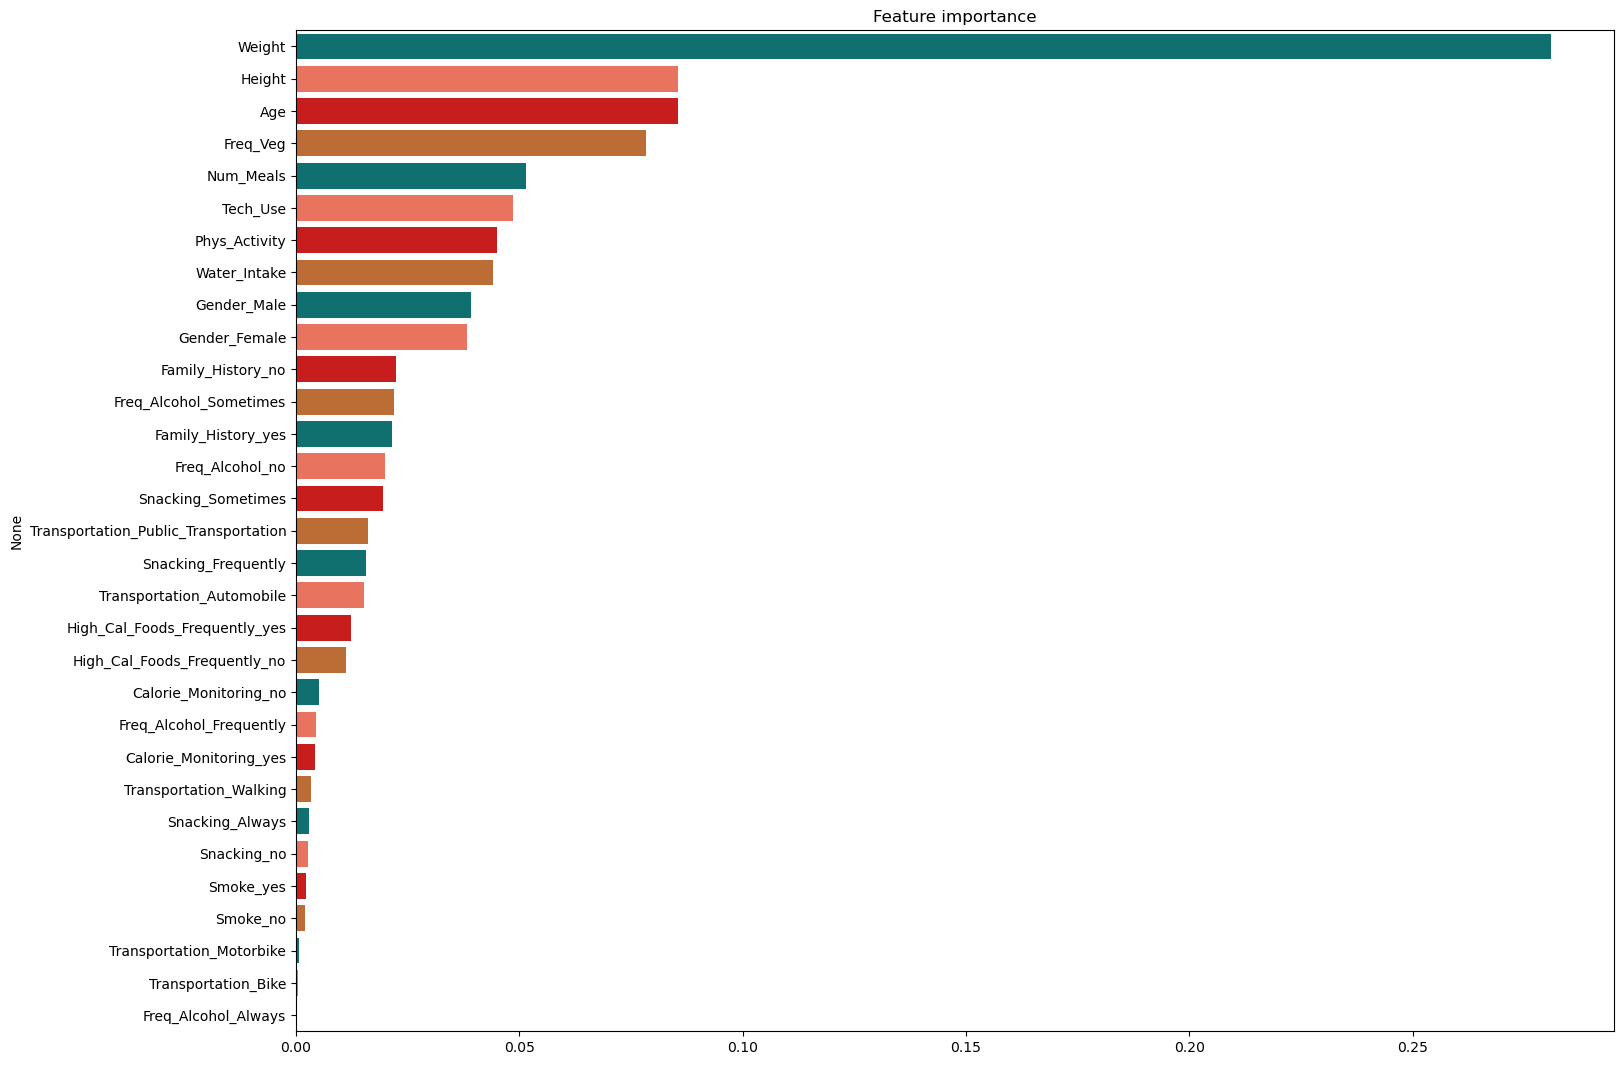

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import plotly.express as px

from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

palette = ['#008080','#FF6347', '#E50000', '#D2691E'] # Creating color palette for plots

clf = RandomForestClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=5000, random_state=13)
clf = clf.fit(X_train, y_train)

fimp = pd.Series(data=clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(17,13))
plt.title("Feature importance")
ax = sns.barplot(y=fimp.index, x=fimp.values, palette=palette, orient='h')

#### Classic feature attributions
Here we try out the global feature importance calcuations that come with XGBoost. 

In [ ]:
xgboot_model = best_models_hyper_tuned.get('xgbc_hyper_tuned')
xgboot_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, nthread=-1,
              num_parallel_tree=None, ...)

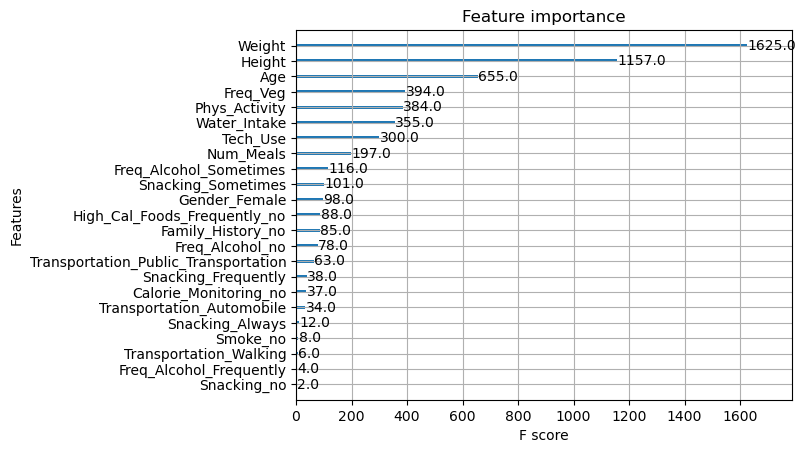

In [ ]:
import xgboost
xgboost.plot_importance(xgboot_model)
#plt.title("xgboost plot_importance(model)")
plt.show()

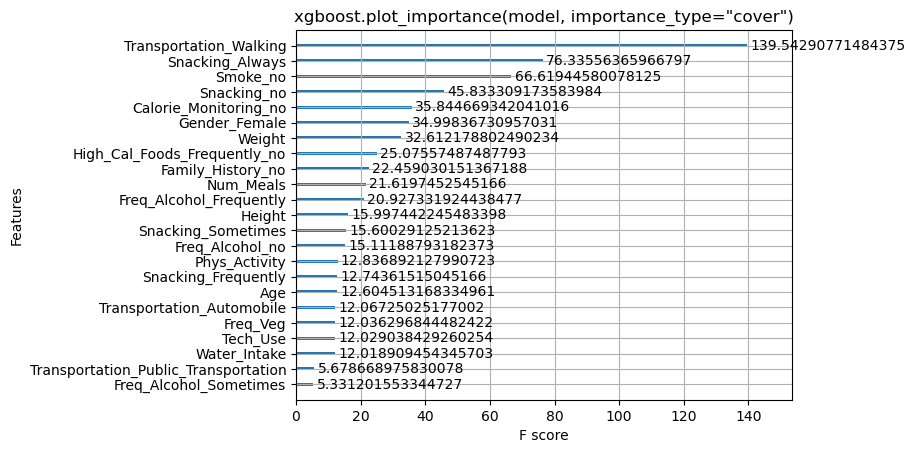

In [ ]:
xgboost.plot_importance(xgboot_model, importance_type="cover")
plt.title('xgboost.plot_importance(model, importance_type="cover")')
plt.show()

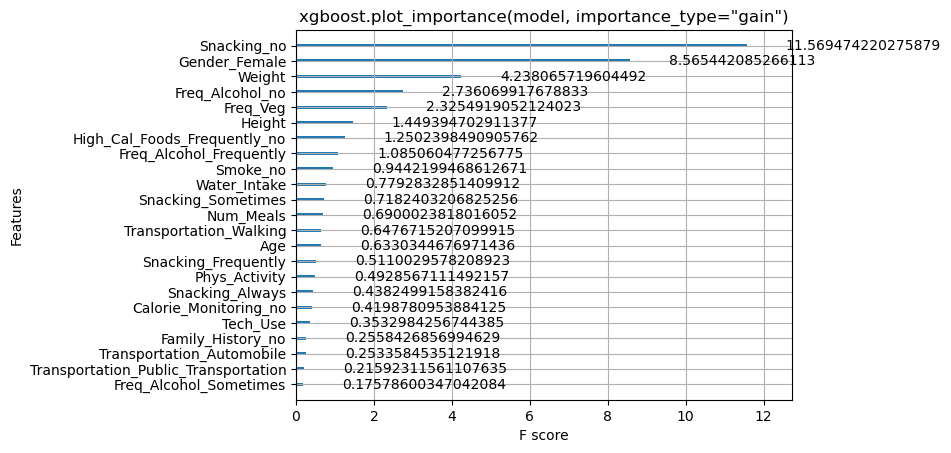

In [ ]:
xgboost.plot_importance(xgboot_model, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()

### SHAP Explainibity

In [ ]:
### code here

import shap

# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(xgboot_model)
shap_values = explainer.shap_values(X_train)

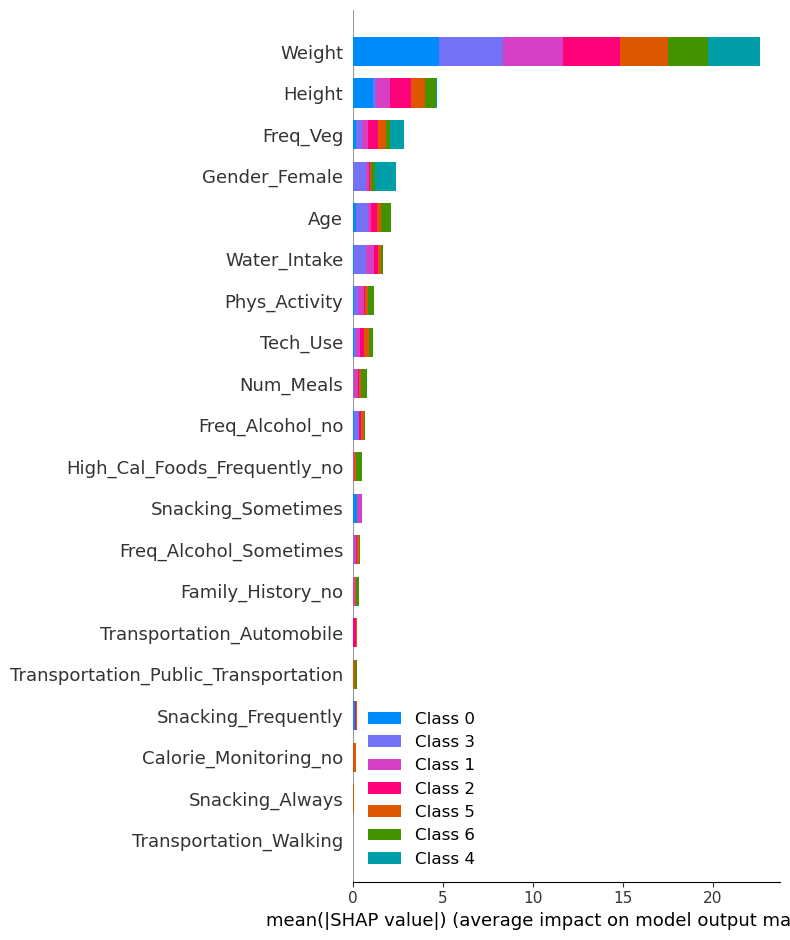

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

## Feature Engineering

Here I will remove the height and weight from the dataset to clearly give indications which parameter has the main effect on the obesity. After Now I will train the XGBoost one more time with new dataset.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Drop Weight and Height
dataset_cleaned = clean_data_df.drop(columns=['Weight', 'Height'])

#  Separate features and target variable
X_new = dataset_cleaned.drop(columns=['Obesity_Level'])
y_new = dataset_cleaned['Obesity_Level']

In [ ]:
# Encode categorical target variable
le = LabelEncoder()
y_encoded_new = le.fit_transform(y)

In [ ]:
# Split data into training and testing sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_encoded_new, stratify=y_encoded_new, test_size=0.2, random_state=42)


In [ ]:
# One-Hot Encode Categorical Features
categorical_features = ['Gender', 'Family_History', 'High_Cal_Foods_Frequently', 'Snacking', 
                        'Smoke', 'Calorie_Monitoring', 'Freq_Alcohol', 'Transportation']
X_train_new = pd.get_dummies(X_train_new, columns=categorical_features, drop_first=True)
X_test_new = pd.get_dummies(X_test_new, columns=categorical_features, drop_first=True)

# Ensure train and test datasets have the same columns
X_test_new = X_test_new.reindex(columns=X_train_new.columns, fill_value=0)

# Step 2: Apply Min-Max Scaling to Numerical Features
num_cols = ['Age', 'Freq_Veg', 'Num_Meals', 'Water_Intake', 'Phys_Activity', 'Tech_Use']
scaler = MinMaxScaler()

X_train_new[num_cols] = scaler.fit_transform(X_train_new[num_cols])
X_test_new[num_cols] = scaler.transform(X_test_new[num_cols])


In [ ]:
xgb_params = {
    'learning_rate': 0.3,
    'n_estimators': 200,
    'nthread': -1,
    'objective': 'multi:softmax',
    'random_state': 42,
    'verbosity': 0
}


In [ ]:
xgb_model = XGBClassifier(xgb_params)
xgb_model.fit(X_train_new, y_train_new)

Pass `objective` as keyword args.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Step 7: Predictions and Performance Metrics
y_pred = xgb_model.predict(X_test_new)
accuracy = accuracy_score(y_test_new, y_pred)
precision = precision_score(y_test_new, y_pred, average='weighted')
recall = recall_score(y_test_new, y_pred, average='weighted')
f1 = f1_score(y_test_new, y_pred, average='weighted')

# Display results
xgb_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}
xgb_metrics

{'Accuracy': 0.8301435406698564,
 'Precision': 0.8304352450360551,
 'Recall': 0.8301435406698564,
 'F1 Score': 0.8293002130561791}

#### All performance metrics dropped as expected but at least know we have a real persepective of real cause of the obersity levels.

Let's also try the Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Step 1: Train Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1  # Utilize all available cores
)
rf_model.fit(X_train_new, y_train_new)

# Step 2: Predictions and Performance Metrics
y_pred_rf = rf_model.predict(X_test_new)
rf_accuracy = accuracy_score(y_test_new, y_pred_rf)
rf_precision = precision_score(y_test_new, y_pred_rf, average='weighted')
rf_recall = recall_score(y_test_new, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test_new, y_pred_rf, average='weighted')

# Display Random Forest Metrics and Feature Importance
rf_metrics = {
    'Accuracy': rf_accuracy,
    'Precision': rf_precision,
    'Recall': rf_recall,
    'F1 Score': rf_f1
}

rf_metrics


{'Accuracy': 0.8397129186602871,
 'Precision': 0.8417072040300481,
 'Recall': 0.8397129186602871,
 'F1 Score': 0.8389217620302508}

Comparison of XGBoost and Random Forest with their performance metrics

In [ ]:
# Combine metrics into a DataFrame for comparison
comparison_df = pd.DataFrame([rf_metrics, xgb_metrics], index=['Random Forest', 'XGBoost'])

# Display the comparison table
comparison_df

,Accuracy,Precision,Recall,F1 Score
Random Forest,0.839713,0.841707,0.839713,0.838922
XGBoost,0.830144,0.830435,0.830144,0.829300


## Feature Importance with using Random Forest, XGBoost and SHAP

In [ ]:
# Compute Random Forest feature importance
rf_feature_importance = rf_model.feature_importances_

# Create a DataFrame for feature importance
rf_feature_importance_df = pd.DataFrame({
    'Feature': X_train_new.columns,
    'Importance': rf_feature_importance
}).sort_values(by='Importance', ascending=False)

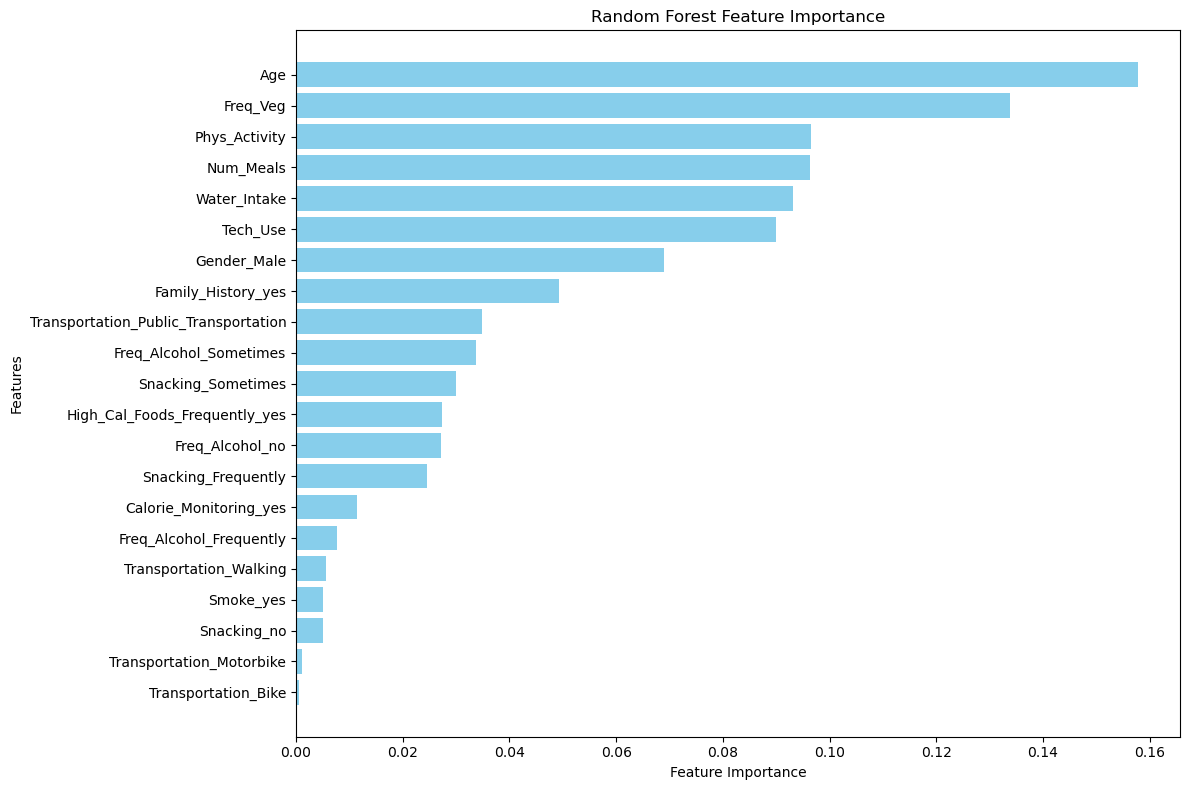

In [ ]:
# Sort the feature importances for better visualization
rf_feature_importance_df = rf_feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 8))
plt.barh(rf_feature_importance_df['Feature'], rf_feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

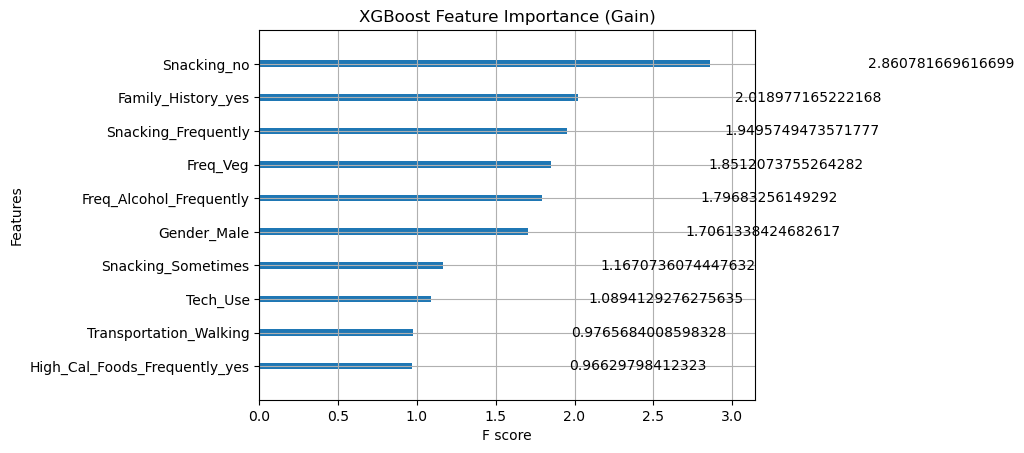

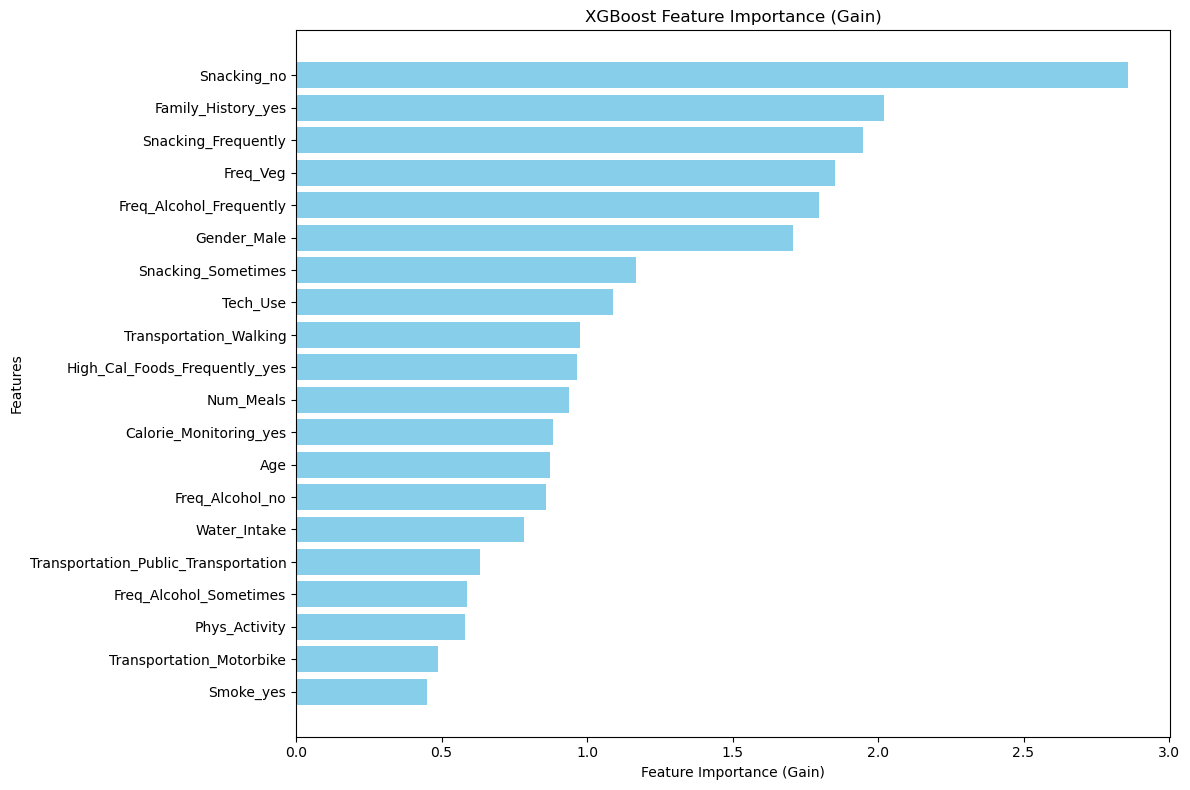

In [ ]:
from xgboost import plot_importance

# Built-in plot with 'gain'
plt.figure(figsize=(12, 8))
plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.title('XGBoost Feature Importance (Gain)')
plt.show()

# Custom plot with 'gain'
feature_importance = xgb_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance (Gain)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:

# SHAP for Random Forest
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_train_new)

# SHAP for XGBoost
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_train_new)


## SHAP Values for Multi-Class Classification

Refer: https://medium.com/biased-algorithms/shap-values-for-multiclass-classification-2a1b93f69c63

Since we have a multi class classification single SHAP explanation is not enough to understand the model better. With referring the Medium post above we will implement the SHAP Values for each indiviual class to udnerstand better the feature importance.

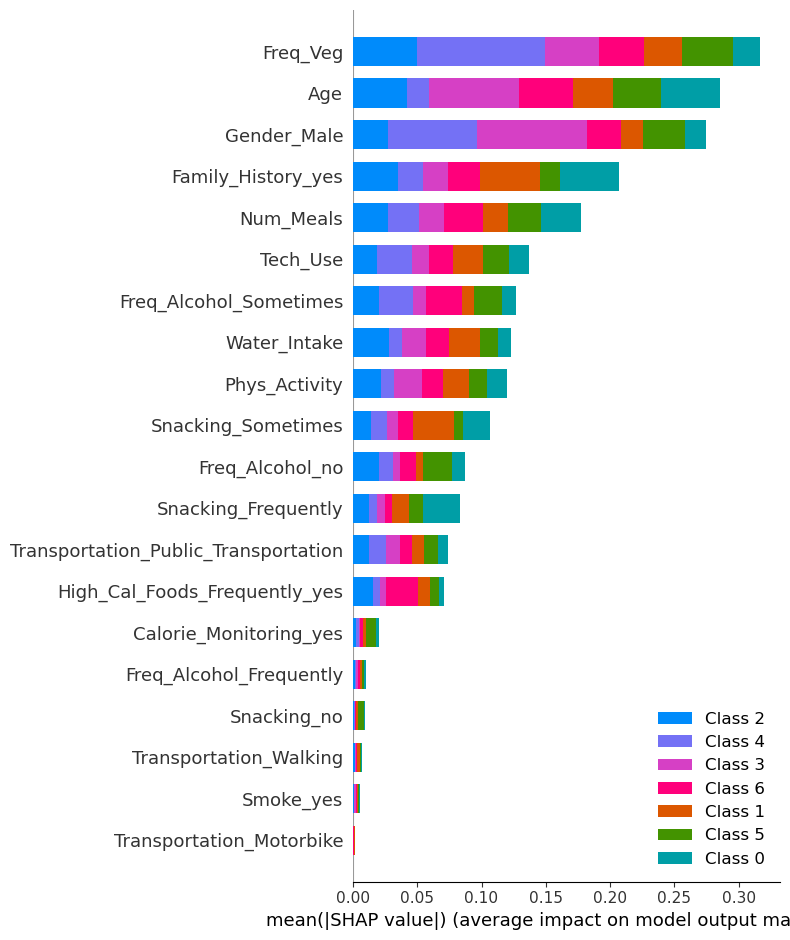

In [ ]:
# Visualize the SHAP Summary Plot for RF

shap.summary_plot(shap_values_rf, X_train_new, plot_type="bar")


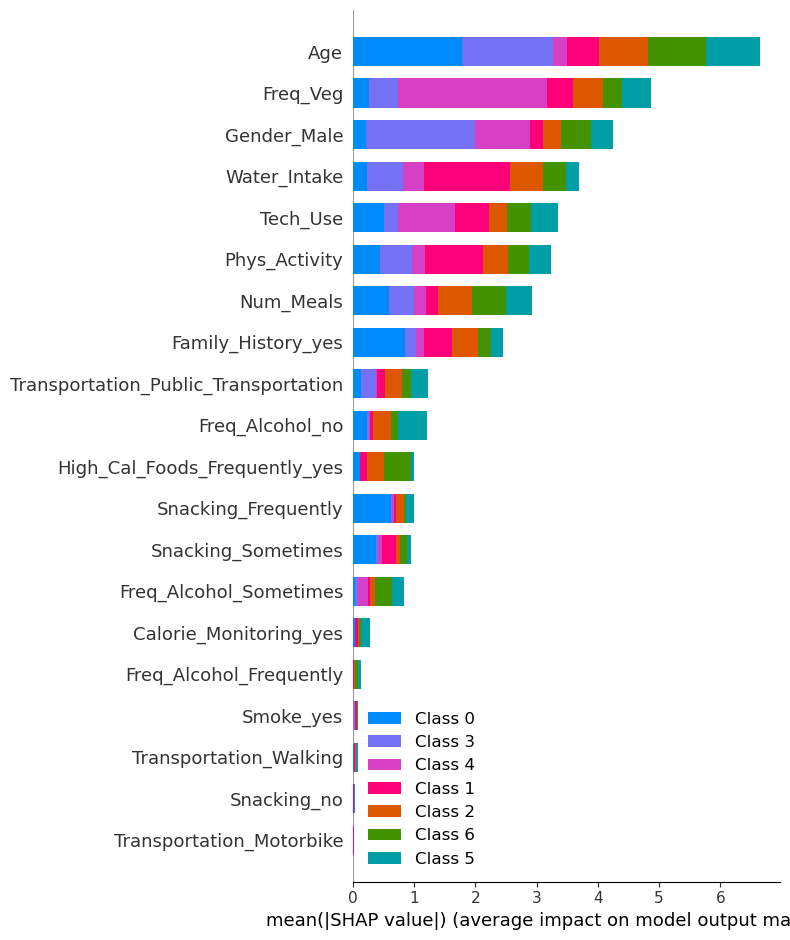

In [ ]:
import xgboost as xgb

# Create DMatrix
dtrain = xgb.DMatrix(X_train_new, label=y_train_new)
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(dtrain)

#the summary plot
shap.summary_plot(shap_values_xgb, X_train_new, plot_type="bar")


## Feature Selection
In this section I will select some of the features and run the code again with selected features and make a comparison

## SHAP Values for Multi-Class Classification

Refer: https://medium.com/biased-algorithms/shap-values-for-multiclass-classification-2a1b93f69c63

Since we have a multi class classification single SHAP explanation is not enough to understand the model better. With referring the Medium post above we will implement the SHAP Values for each indiviual class to udnerstand better the feature importance.

## Conclusion